In [1]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
    import torch
    from IPython.core.display import HTML
    from IPython.display import display
    import os
    print("Running in Google Colab")
    if not torch.cuda.is_available():
        display(HTML("""<div style="background-color: red; font-weight: bold; color: white;">You have not activated a GPU in Google Colab. Follow the instructions in the <code style="color: white;">README</code></div>"""))
    print("Installing requirements")
    requirements_url = "https://raw.githubusercontent.com/willdalh/ml-course/main/requirements.txt"
    if not os.path.exists('requirements.txt'):
        !wget {requirements_url}
    %pip install --user -r requirements.txt

In [2]:
import sys
sys.path.append("../")

# Konvolusjonelle nevrale nettverk

Bildeklassifiseringsmodeller fikk en boost da konvolusjonelle lag begynte å bli tatt i bruk. Konvolusjonelle lag bruker en "sliding window"-mekanisme hvor de samme vektene multipliseres med forskjellige deler av inputtensoren. Disse vektene kaller vi for en _kernel_.

Å få intuisjon på hvordan denne typen lag fungerer kan være krevende, men [dette verktøyet for å visualisere prosessen](https://ezyang.github.io/convolution-visualizer/) kan være til hjelp.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"


Likt med lineære lag, finner vi konvolusjonelle lag i `torch.nn`. Nå må vi spesifisere størrelsen på vår kernel, og hvor store hopp den skal gjøre når den beveger seg langs inputen. Det viktigste parameteret er derimot hvor mange kanaler som skal inn (`in_channels`), og hvor mange som skal ut (`out_channels`). De kan ansees som de ekvivalente til `in_features` og `out_features` for lineære lag. For å forstå hva parameterne betyr anbefales det sterkt å bruke verktøyet som ble linket til over. 

In [4]:
layer = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
layer

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

La oss prøve det konvolusjonelle laget på en bildetensor

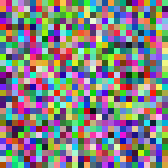

In [5]:
from utils.visualize import visualize
image = torch.rand(3, 28, 28) * 2 - 1
visualize(image)

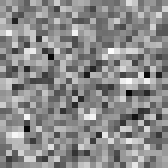

In [6]:
new_image = layer(image)
visualize(new_image)

Siden vi spesifiserte `out_channels = 1`, vil resultatet bli et gråskala-bilde. Når vi bruker konvolusjonelle lag i nevrale nettverk er det typisk å la antall kanaler som er i spill overgå hva som gir mening for oss. For eksempel kan man ha et `nn.Conv2d(in_channels=1, out_channels=16)`, altså at et gråskala-bilde blir til et bilde med 16 kanaler. Tanken er at modellen lærer seg å hente ut viktige egenskaper ved input-bildet og lagre det i ytterligere kanaler. 

Vi tar i bruk `nn.Sequential` for å lage sekvenser av lag som dataen flyter gjennom.

In [7]:
seed = 4
torch.manual_seed(seed) # Set random seed for reproducibility
torch.backends.cudnn.deterministic = True
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # 1x28x28 -> 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x28x28 -> 16x14x14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 16x14x14 -> 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x14x14 -> 32x7x7
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 32x7x7 -> 64x7x7
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x7x7 -> 64x3x3
            nn.Flatten(), # 64x3x3 -> 576
            nn.Linear(576, 10) # 576 -> 10
        )

    def logits(self, data):
        return self.model(data)
    
    def forward(self, data):
        logits = self.logits(data)
        return F.softmax(logits, dim=1)
    
model = CNNModel() # Initialize model
model.to(device) # Move model to GPU device

CNNModel(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=576, out_features=10, bias=True)
  )
)

In [8]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 29066


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Pipeline of processing operations
image_processing = transforms.Compose([
    transforms.ToTensor(), # Cast into torch.Tensor
    transforms.Normalize((0.5,), (0.5,)) # Pixel-values will range in [-1, 1]
])

train_dataset = MNIST(root='../data', train=True, transform=image_processing, download=True)
test_dataset = MNIST(root='../data', train=False, transform=image_processing, download=True) # Test data for later
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32) # Iterable that provides batches of 32 images

In [11]:
from tqdm import tqdm # Progress bar

num_epochs = 3

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as pbar:
        pbar.set_description(f"Epoch {epoch}")
        for i, (data, labels) in enumerate(pbar):
            data = data.to(device)
            labels = labels.to(device)
            pred = model.logits(data) # Query model for predictions
            loss = loss_fn(pred, labels)
            
            loss.backward() # Propagate the computational graph and calculate gradients
            optimizer.step() # Uses the calculated gradients on the registered parameters to perform an update
            optimizer.zero_grad() # Remove the gradients

Epoch 2: 100%|██████████| 1875/1875 [00:10<00:00, 183.26batch/s]


In [12]:
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

correct = 0
for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)

    pred = model.forward(data)
    correct += torch.sum(pred.argmax(dim=1) == labels)
accuracy = correct/len(test_dataset)

print(f"The accuracy of the model on the test set is {accuracy*100:.2f}%")

The accuracy of the model on the test set is 99.00%


Med en arkitektur som tar i bruk konvolusjonelle lag, klarer modellen å strekke seg over 99% nøyaktighet på testsettet. Overraskende nok, så har denne modellen mindre enn $\frac{1}{5}$ av antall vekter enn den fullstendige lineære modellen som ble trent i `neural_networks.ipynb`, men klarer likevel å oppnå 4 prosentpoeng høyere nøyaktighet. Dette demonstrerer fordelen med konvolusjonelle lag.

# Lagring av modeller
PyTorch-modeller kan enkelt lagres for å tas i bruk senere.

In [13]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, "../saved_models/model.pt")

In [14]:
model = CNNModel() # new untrained model
model.load_state_dict(torch.load("../saved_models/model.pt"))
model.to(device)

/tmp/ipykernel_7826/4040206747.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../saved_models/model.pt"))


CNNModel(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=576, out_features=10, bias=True)
  )
)

In [15]:
correct = 0
for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)

    pred = model.forward(data)
    correct += torch.sum(pred.argmax(dim=1) == labels)
accuracy = correct/len(test_dataset)
print(f"The accuracy of the loaded model on the test set is {accuracy*100:.2f}%")

The accuracy of the loaded model on the test set is 99.00%
